In [71]:
import numpy as np
from numpy.linalg import eigh, inv, eigvals, eigh, eig, norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from fitter import Fitter

In [72]:
N = 100
N_samples = 50
sigmas = (0.001, 0.5, 1, 2)

# M is a real symmetric orthogonal matrix with M = M.T = M^-1
# Orthogonal matrices are not in general symmetric!
def generate_M():
    H = np.random.normal(loc=0, scale=1, size=N*N).reshape((N, N))
    M = (H + H.T) / np.sqrt(2*N)
    D, P = eigh(M)
    D = np.diag(np.sign(D))
    M = P @ D @ inv(P)
    return M

# Wigner Matrix NxN, i.e. real symmetric matrix with IID Gaussian random numbers with 
# zero mean and variance sigma^2/N 
def generate_X(sigma):
    H = np.random.normal(loc=0, scale=1, size=N*N).reshape((N, N))
    X = sigma*(H + H.T) / np.sqrt(2*N)
    return X

# E = M + X 

100%|██████████| 50/50 [00:00<00:00, 166.20it/s]


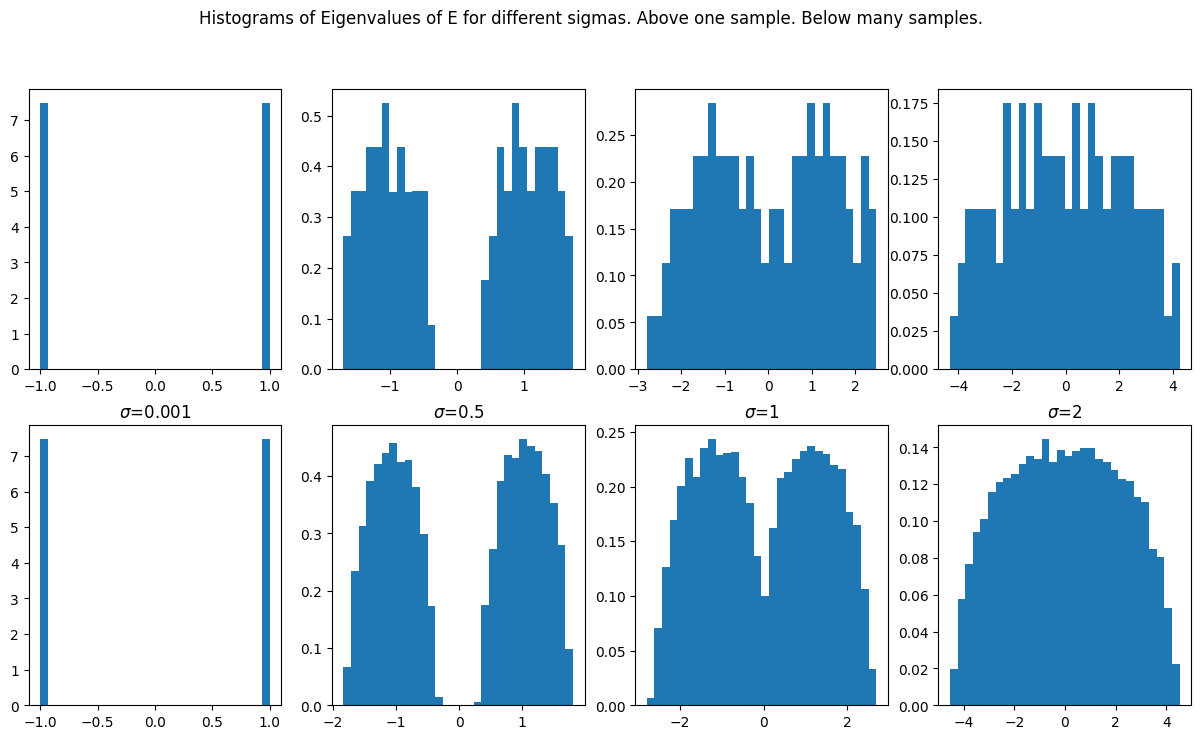

In [73]:
fig, ax = plt.subplots(nrows=2, ncols=len(sigmas), figsize=(15, 8))
fig.suptitle("Histograms of Eigenvalues of E for different sigmas. Above one sample. Below many samples.")
for sigma_idx, sigma in enumerate(sigmas):
    M = generate_M()
    eigs_list = []
    for i in tqdm(range(N_samples)):
        X = generate_X(sigma)
        E = M + X
        eigs = eigvals(E)
        if i == 0:
            ax[0, sigma_idx].hist(eigs, density=True, bins=30)
        eigs_list.extend(eigs)
        
    # Plot Eigenvalues of E
    ax[1, sigma_idx].hist(eigs_list, density=True, bins=30)
    ax[1, sigma_idx].set_title(f"$\sigma$={sigma}")

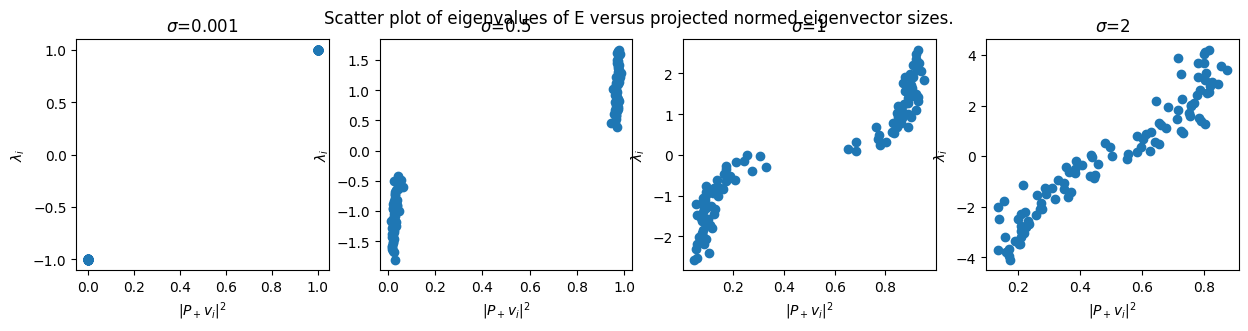

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=len(sigmas), figsize=(15, 3))
fig.suptitle("Scatter plot of eigenvalues of E versus projected normed eigenvector sizes.")
for sigma_idx, sigma in enumerate(sigmas):
    M = generate_M()
    X = generate_X(sigma)
    E = M + X

    eig_vals, eig_vecs = eigh(E)
    normalized_eig_vecs = np.apply_along_axis(lambda x: x/norm(x), 
                                            axis=0, 
                                            arr=eig_vecs)

    P_plus = 1/2*(M + np.identity(N))
    projected_eig_vecs = P_plus @ normalized_eig_vecs
    
    x = np.apply_along_axis(lambda x: norm(x)**2, axis=0, arr=projected_eig_vecs)
    ax[sigma_idx].scatter(x, eig_vals)
    ax[sigma_idx].set_title(f"$\sigma$={sigma}")
    ax[sigma_idx].set_ylabel("$\lambda_i$")
    ax[sigma_idx].set_xlabel("$|P_+v_i|^2$")

In [75]:
# (e)
sigma = sigmas[2]
eig_val_spacings = []
for i in tqdm(range(N_samples)):
    M = generate_M()
    X = generate_X(sigma)
    E = M + X
    eig_vals, eig_vecs = eigh(E)
    eig_vals.sort()
    eig_val_spacing = [b - a for a,b in zip(eig_vals[:-1], eig_vals[1:])]
    eig_val_spacings.extend(eig_val_spacing)

100%|██████████| 50/50 [00:02<00:00, 24.24it/s]


2024-06-02 16:53:08.212 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=227.857955)
2024-06-02 16:53:08.240 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=23.745995)
2024-06-02 16:53:08.769 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=2369.577534)
2024-06-02 16:53:08.906 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=16.724528)
2024-06-02 16:53:09.085 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=33.474742)


Text(0.5, 1.0, 'Distribution of Eigenvalue spacing $s_k = \\lambda_k - \\lambda_{k-1}$ of E')

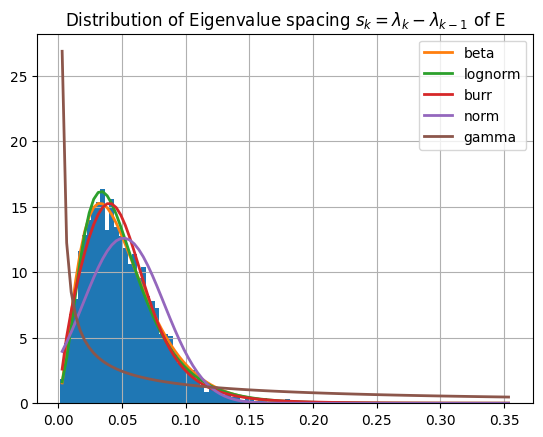

In [76]:
f = Fitter(eig_val_spacings,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
_ = f.fit()
f.summary()
plt.title("Distribution of Eigenvalue spacing $s_k = \lambda_k - \lambda_{k-1}$ of E")

In [77]:
sigma = sigmas[2]
all_eig_vals = []
for i in tqdm(range(N_samples)):
    M = generate_M()
    X = generate_X(sigma)
    E = M + X
    eig_vals, eig_vecs = eigh(E)
    all_eig_vals.extend(eig_vals)

all_spacings = []
for i in tqdm(range(N_samples)):
    sample = np.random.choice(all_eig_vals, 100)
    sample.sort()
    eig_val_spacing = [b - a for a,b in zip(sample[:-1], sample[1:])]
    all_spacings.extend(eig_val_spacing)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 3322.85it/s]


(0.0, 0.05032863047718944)


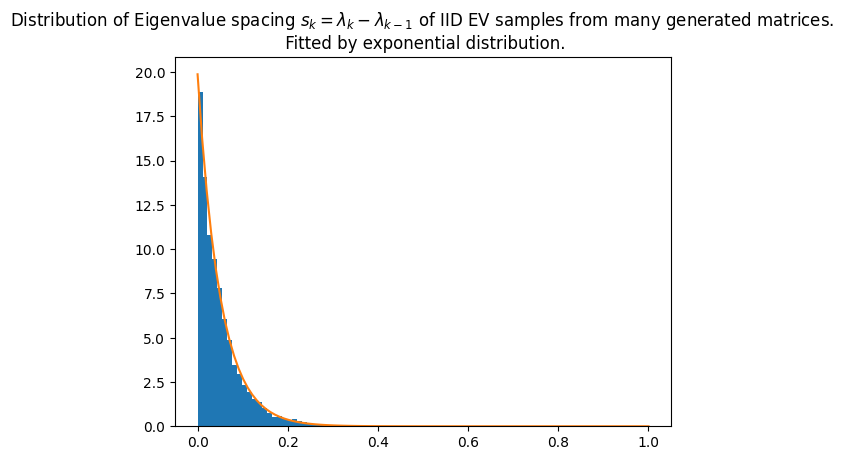

In [78]:
import scipy.stats as ss
exp = ss.expon.fit(all_spacings)
print(exp)
rX = np.linspace(0,1, 100)
rP = ss.expon.pdf(rX, *exp)

_ = plt.hist(all_spacings, density=True, bins=50)
_ = plt.plot(rX, rP)
_ = plt.title("Distribution of Eigenvalue spacing $s_k = \lambda_k - \lambda_{k-1}$ of IID EV samples from many generated matrices. \n Fitted by exponential distribution.")

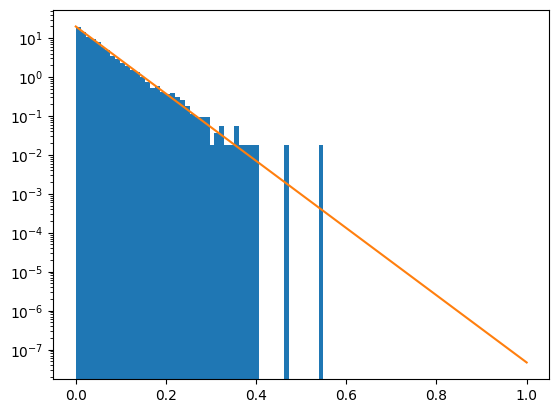

In [79]:
_ = plt.hist(all_spacings, density=True, bins=50)
plt.yscale('log')
plt.plot(rX, rP)